### Import Package

In [1]:
import numpy as np
###list of data files
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import time
import math
from itertools import groupby
from operator import itemgetter
import more_itertools as mit
import time
from numpy import array
from numpy.random import rand
import datetime

### Rating

* **Assign the rating to the security based on its average rating score through the period**

In [2]:
def assign_rating(x):
    x = float(x)
    if x < 0:
        return 'NR'
    elif x >0 and x<=0.5:
        return 'D'
    elif x > 0.5 and x<=1.5:
        return 'C'
    elif x > 1.5 and x<=2.5:
        return 'CC-'
    elif x > 2.5 and x<=3.5:
        return 'CC'
    elif x >3.5 and x<=4.5:
        return 'CC+'
    elif x >4.5 and x <=5.5:
        return 'CCC-'
    elif x >5.5 and x <=6.5:
        return 'CCC'
    elif x >6.5 and x<=7.5:
        return 'CCC+'
    elif x >7.5 and x <= 8.5:
        return 'B-'
    elif x>8.5 and x <=9.5:
        return 'B'
    elif x> 9.5 and x <= 10.5:
        return 'B+'
    elif x >10.5 and x<=11.5:
        return 'BB-'
    elif x > 11.5 and x<=12.5:
        return 'BB'
    elif x >12.5 and x<=13.5:
        return 'BB+'
    elif x>13.5 and x <=14.5:
        return 'BBB-'
    elif x>14.5 and x<=15.5:
        return 'BBB'
    elif x>15.5 and x<=16.5:
        return 'BBB+'
    elif x>16.5 and x<=17.5:
        return 'A-'
    elif x > 17.5 and x<=18.5:
        return 'A'
    elif x >18.5 and x<=19.5:
        return 'A+'
    elif x>19.5 and x<=20.5:
        return 'AA-'
    elif x >20.5 and x<=21.5:
        return 'AA'
    elif x>21.5 and x<=22.5:
        return 'AA+'
    else:
        return 'AAA'

* **Calcuate the average Rating for security**

In [67]:
def process_rating_data(data):
    #data = data[data['KeyDate']<=end_date]
    rating = data.groupby('SecurityID',as_index=False).mean()
    rating['RatingSP'] = rating['RatingSP'].apply(lambda x:assign_rating(x))
    return rating

### Grab Cluster information from Security data, Rating data
* **Input:**
    * Clusters_index
    * Orginal Gspread series
    * Secuirty data
    * Rating_data
* **Output:**
    * A list conatins a lists of pandas dataframes

In [4]:
def grab_clusters(clusters,bond_spread_list,security_data,rating_data):
    temp_list = []
    for cluster in clusters:
        temp_list2 = []
        for bond_index in cluster:
            bond_id = bond_spread_list[bond_index][1]
            bond_Sector = security_data[security_data['SecurityID']==bond_id].SecuritySector.iloc[0]
            bond_Industry = security_data[security_data['SecurityID'] == bond_id].SecurityIndustry.iloc[0]
            bond_sub_Industry = security_data[security_data['SecurityID'] == bond_id].SecuritySubIndustry.iloc[0]
            bond_Seniority = security_data[security_data['SecurityID'] == bond_id].Seniority.iloc[0]
            bond_Issuer =security_data[security_data['SecurityID'] == bond_id].Issuer.iloc[0]
            bond_countryrisk =security_data[security_data['SecurityID'] == bond_id].CountryRisk.iloc[0]
            bond_amountIssued =security_data[security_data['SecurityID'] == bond_id].AmountIssued.iloc[0]
            bond_coupon =security_data[security_data['SecurityID'] == bond_id].Coupon.iloc[0]
            bond_MaturityDate =security_data[security_data['SecurityID'] == bond_id].MaturityDate.iloc[0]
            bond_issuedate =security_data[security_data['SecurityID'] == bond_id].IssueDate.iloc[0][:4]
            try:
                bond_rating=rating_data[rating_data['SecurityID'] == bond_id].RatingSP.iloc[0]
            except:
                bond_rating = 'Not Founded'
            temp_tuple = (bond_id,bond_Sector,bond_Industry,bond_sub_Industry,bond_Seniority,bond_Issuer,bond_countryrisk,bond_rating,bond_amountIssued,bond_coupon,bond_issuedate,bond_MaturityDate)
            temp_list2.append(temp_tuple)
        temp_list.append(temp_list2)
    return temp_list

#### Transfer a list of Cluster_list to a pandas DataFrame

In [5]:
def transfer_to_list_of_pd(clusters_list):
    clusters_data_list = []
    for i in clusters_list:
        temp_data = pd.DataFrame(i, columns =['SecurityID', 'Sector', 'Industry','Sub_Industry','Seniority','Issuedby','Country','Rating','AmountIssued','Coupon','IssueDate','MaturityDate'])
        clusters_data_list.append(temp_data)
    return clusters_data_list

#### Get Cluster index

In [63]:
def create_cluster_list(cluster_index):
    temp_1 = []
    for i in np.unique(cluster_index):
        temp_2 = []
        for n in range(0,len(cluster_index)):
            if cluster_index[n] == i:
                temp_2.append(n)
        temp_1.append(temp_2)
    return temp_1

### Helper function: Speeding up the processing time

In [6]:
def merge_left_right(data1,data2):
    temp_data = data1.append(data2)
    return temp_data

def merg_sort(list_data):
    list_length = len(list_data)
    if list_length == 1:
        output = list_data[0][2]
        return output
    else:
        mid_point = math.floor(list_length/2)
        #print(len(list_data[:mid_point]))
        left = list_data[mid_point:]
        right = list_data[:mid_point]
        return merge_left_right(merg_sort(left), merg_sort(right))

#### A function to grab Gspread for a defined period

In [7]:
def sliding_windows(data,period_of_time,start_date):
    #transfer start_date to datetime()
    time_list = start_date.split('-')
    year = int(time_list[0])
    month = int(time_list[1])
    date = int(time_list[2])
    start_datetime = datetime.datetime(year, month, date)
    data['KeyDate'] = pd.to_datetime(data['KeyDate'])
    data['MaturityDate'] = pd.to_datetime(data['MaturityDate'])
    data['IssueDate'] = pd.to_datetime(data['IssueDate'])
    ###find the end date:
    end_datetime = start_datetime + datetime.timedelta(days=period_of_time)
    end_date = str(end_datetime.date())
    #####select data before the end_date
    data = data[data['KeyDate'] <= end_date]
    data = data[data['IssueDate'] <= start_datetime]
    data = data[data['MaturityDate'] >= end_date]
    return data

#### The function to fill the NAs in the Gspread function(1)

In [8]:
def apply_fill(data_list,index):
    for i in data_list:
        try:
            fill_the_GSpeard(i)
        except:
            index.append(i)
    return index,data_list

#### Combine the data togther

A Helper function to help read data

In [12]:
def merge_data(lists,initial_data):
    data = initial_data
    for file in lists:
        path = 'C:\\Users\\y437l\\OneDrive\\MMAI\\Capstone\\Data\\{}'.format(file)
        #path = '/Users/yangli/OneDrive/MMAI/Capstone/Data/{}'.format(file)
        temp_data = pd.read_csv(path)
        print(len(temp_data))
        data = data.append(temp_data)
        print(len(data))
    return data

Merge the data togther

In [13]:
start_time = time.time()
security_data = pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
#security_data = pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
security_data = security_data[['SecurityID','Currency','IssueDate','MaturityDate']]
### merge spread data togther
sc = MinMaxScaler()
data = pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/1.csv")
#data = pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/Data/1.csv")
file_lists = ['14426.csv','24001.csv','36128.csv','48087.csv','55086.csv']
final_data = merge_data(file_lists,data)
#final_data = data
###left join the currency data into the spread data
final_data = final_data.merge(security_data, on=['SecurityID'], how='left')
final_data.dropna(subset=["ZSpread"],inplace=True)
###select currency as USD
final_data_1 = final_data[final_data.Currency == 'USD']
final_data = final_data_1.groupby('SecurityID')
###create a list of bond with data
bonds_list = [final_data.get_group(x) for x in final_data.groups]

1054948
2103331
961878
3065209
1074473
4139682
869630
5009312
584171
5593483


In [14]:
final_data2 = merge_data(file_lists,data)

1054948
2103331
961878
3065209
1074473
4139682
869630
5009312
584171
5593483


In [15]:
security_data = pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")

#### A function to help to fill missing Spread
* function(1) applys in here 

In [16]:
def fill_the_GSpeard(data):
    ##calucate the spread between gspread and z spread if the gspread is not 0.
    data['Spread_G_Z'] = data.GSpread - data.ZSpread
    ###find the nan data's index in the data:
    index_with_indicator = data.GSpread.isna()
    index_with_indicator = index_with_indicator.tolist()
    index_list = []
    for indx in range(0,len(index_with_indicator)):
        if index_with_indicator[indx] == True:
            index_list.append(indx)
    #print(index_list)
    ##find concustive missing value:
    ##example:[(22, 39), 303, (326, 343), 607]
    star_end_dates = find_ranges(index_list)
    missing_date_dict={}
    for periods in star_end_dates:
        if type(periods) !=tuple:
            missing_date_dict[str(periods)] = spread_slope(data,periods)
            value = data.Spread_G_Z.iloc[periods-1]+missing_date_dict[str(periods)][3]
            print(value)
            data.GSpread.iloc[periods] = data.ZSpread.iloc[periods]+value
            print(data.GSpread.iloc[periods])
        else:
            missing_date_dict['{}-{}'.format(periods[0],periods[1])] = spread_slope(data, periods)
            star = missing_date_dict['{}-{}'.format(periods[0],periods[1])][0]
            end = missing_date_dict['{}-{}'.format(periods[0],periods[1])][1]
            slope = missing_date_dict['{}-{}'.format(periods[0],periods[1])][3]
            for days in range(star+1,end):
                value = data.Spread_G_Z.iloc[star] + (days-star)*slope
                data.GSpread.iloc[days] = data.ZSpread.iloc[days]+value
    print(missing_date_dict)
    #if missing_date_dict['{}-{}'.format(periods[0],periods[1])][3] >=1:
        #print(missing_date_dict)
        #print("Warning {}".format(data.SecurityID.iloc[0]))
    return data

#### Find the missing range in the Gspread

In [17]:
def find_ranges(iterable):
    """Yield range of consecutive numbers."""
    for group in mit.consecutive_groups(iterable):
        group = list(group)
        if len(group) == 1:
            yield group[0]
        else:
            yield group[0], group[-1]

#### Find the slope for that period

In [18]:
def spread_slope(data,input):
    if type(input) != tuple:
        star = input-1
        end = input+1
    else:
        star = input[0] - 1
        end = input[1] + 1
    if end == len(data):
        slope = data.Spread_G_Z.iloc[star]
        end = 'None'
        gap = 1
    else:
        print(input)
        star_point = data.Spread_G_Z.iloc[star]
        print(star_point)
        end_point = data.Spread_G_Z.iloc[end]
        print(end_point)
        gap = (end-star)
        print(gap)
        slope = (end_point - star_point) / gap
        print(slope)
    return (star, end, gap,slope)

#### Helper function to select Gspread data

In [19]:
def select_data(num,listoftuble):
    temp_list = []
    for i in listoftuble:
        if i[0] == num:
            temp_list.append(i)
    return temp_list

## Select the data with only spread percentage change.
def select_spread_data(listoftuble):
    temp_list = []
    for i in listoftuble:
        temp_list.append(i[2])
    return temp_list

#### fill the data, and print out the the suspectious slope

In [20]:
problemtic_data_index =[]
problem_data_index,bonds_list = apply_fill(bonds_list,problemtic_data_index)
print("--- %s seconds ---" % (time.time() - start_time))

c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

{}
{}
{}
{}
{}
{}
{}
276
26.775600999999995
-0.94667400000003
2
-13.861137500000012
12.914463499999982
271.48346349999997
{'276': (275, 277, 2, -13.861137500000012)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
276
41.79283500000008
59.27663600000005
2
8.741900499999986
50.53473550000007
-2845.6052645
{'276': (275, 277, 2, 8.741900499999986)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
255
112.42378400000052
190.6316340000003
2
39.10392499999989
151.5277090000004
-4344.442290999999
{'255': (254, 256, 2, 39.10392499999989)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(130, 134)
-26.62099999999998
-26.424000000000035


{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
284
1.657284000000061
0.3258099999999331
2
-0.665737000000064
0.9915469999999971
424.585547
{'284': (283, 285, 2, -0.665737000000064)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(127, 131)
5.444000000000017
1.5080000000000098
6
-0.6560000000000011
{'127-131': (126, 132, 6, -0.6560000000000011)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(290, 291)
-36.68546799999996
281.73619599999984
3
106.1405546666666
320
141.89872099999957
38.65168700000004
2
-51.623516999999765
90.2752039999998
-3538.954796
{'290-291': (289, 292, 3, 106.1405546666666), '320': (319, 321, 2, -51.623516999999765)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(128, 132)
3.847999999999999
2.032900000000012
6
-0.3025166666666645
{'128-132': (127, 133, 6, -0.30251666666666

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(130, 134)
-2.3470000000000084
-0.4309999999999832
6
0.3193333333333375
{'130-134': (129, 135, 6, 0.3193333333333375)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
284
363.59173999999985
31.113579999999274
2
-166.23908000000029
197.35265999999956
-4560.17734
{'284': (283, 285, 2, -166.23908000000029)}
{}
255
3.8587269999999876
69.81752999999998
2
32.979401499999994
36.83812849999998
482.6931285
{'255': (254, 256, 2, 32.979401499999994)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
276
2.2673340000000053
0.

291
41.44098500000018
287.61312699999985
2
123.08607099999983
164.52705600000002
-1831.942944
{'291': (290, 292, 2, 123.08607099999983)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(0, 92)
3.7966160000000286
10.335190000000011
94
0.06955929787234025
95
6.263326000000006
-12.938169000000002
2
-9.600747500000004
-3.337421499999998
120.17757850000001
157
-13.207356000000004
24.843332000000004
2
19.025344000000004
5.817988
138.20398799999998
(177, 180)
36.896581
35.452231999999995
5
-0.2888698000000005
(182, 184)
35.452231999999995
34.046115
4
-0.3515292499999987
187
28.884895000000014
35.26785600000001
2
3.1914804999999973
32.07637550000001
175.7373755
190
37.91332099999998
31.7440160

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
249
112.42378400000052
26.12038799999999
2
-43.151698000000266
69.27208600000026
-3645.5879139999997
{'249': (248, 250, 2, -43.151698000000266)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
283
363.94854200000054
26.197425000000067
2
-168.87555850000024
195.0729835000003
-1694.5870164999997
{'283': (282, 284, 2, -168.87555850000024)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(290, 291)
8.90813700000001
11.044021000000043
3
0.7119613333333442
{'290-291': (289, 292, 3, 0.7119613333333442)}
{}
{}
{}
276
5.497528999999986
1.132752000000

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
274
-9.079669999999965
-14.058916999999951
2
-2.4896234999999933
-11.569293499999958
721.6027065000001
{'274': (273, 275, 2, -2.4896234999999933)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
282
363.5939149999999
24.035890999999992
2
-169.77901199999997
193.81490299999996
-1172.5750970000001
{'282': (281, 283, 2, -169.77901199999997)}
{}
281
363.5939149999999
24.035890999999992
2
-169.77901199999997
193.81490299999996
-1150.795097
{'281': (280, 282, 2, -169.77901199999997)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
252
-10.022410000000036
-10.96745199999998
2
-0.472520999999972
-10.494931000000008
592.8470689999999
255
-10.576115999999956
-11.714049000000045
2
-0.5689665000000446
-11.145082500000001
549.9559174999999
{'252': (251, 253, 2, -0.472520999999972), '255': (25

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
150
3.1186820000000353
-0.2817099999999755
2
-1.7001960000000054
1.41848600000003
513.867486
(164, 165)
6.238938999999959
8.417663999999945
3
0.7262416666666619
{'150': (149, 151, 2, -1.7001960000000054), '164-165': (163, 166, 3, 0.7262416666666619)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
239
1.455013999999892
0.9045600000000604
2
-0.27522699999991573
1.1797869999999762
711.881787
{'239': (238, 240, 2, -0.27522699999991573)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
276
1.3367190000000164
-2.251427999999976
2
-1.794073499999996
-0.4573544999999797
276.9886455000001
{'276': (275, 277, 2, -1.794073499999996)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
290
16.64072300000001
8.41956399999998
2
-4.11057950

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
252
117.26143000000002
114.37064500000042
2
-1.445392499999798
115.81603750000022
-4578.353962499999
{'252': (251, 253, 2, -1.445392499999798)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
252
-12.623970000000043
-16.149389000000042
2
-1.7627094999999997
-14.386679500000042
295.7943204999999
276
-13.475033999999994
-16.87120699999997
2
-1.698086499999988
-15.173120499999982
310.4298795
{'252': (251, 253, 2, -1.7627094999999997), '276': (275, 277, 2, -1.698086499999988)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
276
5.576534999999922
3.6941590000000133
2
-0.9411879999999542
4.6353469999999675
620.651347
{'276': (275, 277, 2,

361.26833250000004
253
4.3124670000000265
3.0262220000000184
2
-0.643122500000004
3.6693445000000224
357.5513445
{'250': (249, 251, 2, -2.6149795000000324), '253': (252, 254, 2, -0.643122500000004)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
276
44.57383200000004
62.50722799999858
2
8.966697999999269
53.54052999999931
-11104.35947
{'276': (275, 277, 2, 8.966697999999269)}
{}
276
14.138897999999983
57.974983000000066
2
21.91804250000004
36.056940500000024
-7827.0930595
{'276': (275, 277, 2, 21.91804250000004)}
290
-21.427305999999987
0.027670000000000528
2
10.727487999999994
-10.699817999999993
282.289182
{'290': (289, 291, 2, 10.727487999999994)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(201, 202)
-6.530742999999916
-8.74132099999997
3
-0.7368593333333516
{'201-202': (200, 203, 3, -0.7368593333333516)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


{}
{}
291
10.741885000000025
24.420483000000047
2
6.839299000000011
17.581184000000036
364.0061840000001
{'291': (290, 292, 2, 6.839299000000011)}
{}
{}
{}
{}
{}
284
-1.3532069999999692
-25.824419000000006
2
-12.235606000000018
-13.588812999999988
248.90318700000003
{'284': (283, 285, 2, -12.235606000000018)}
255
1.9929220000000214
0.9324740000000133
2
-0.530224000000004
1.4626980000000174
354.123698
276
1.9972420000000284
-0.9602199999999925
2
-1.4787310000000105
0.5185110000000179
358.74151100000006
{'255': (254, 256, 2, -0.530224000000004), '276': (275, 277, 2, -1.4787310000000105)}
{}
{}
{}
{}
284
375.3705339999997
40.86566999999923
2
-167.25243200000023
208.11810199999945
-7140.761898000001
{'284': (283, 285, 2, -167.25243200000023)}
{}
276
9.069058999999982
35.524632999999994
2
13.227787000000006
22.296845999999988
348.76384599999994
{'276': (275, 277, 2, 13.227787000000006)}
275
-11.33038799999997
-16.353812000000005
2
-2.511712000000017
-13.842099999999988
306.9389
(289, 290)
-

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
255
108.54709700000012
23.33074099999999
2
-42.608178000000066
65.93891900000006
-3182.821081
{'255': (254, 256, 2, -42.608178000000066)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
213
-5.892158999999992
-11.388111000000038
2
-2.7479760000000226
-8.640135000000015
420.359865
{'213': (212, 214, 2, -2.7479760000000226)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
276
1.7243859999999813
-1.1770759999999427
2
-1.450730999999962
0.2736550000000193
279.793655
{'276': (275, 277, 2, -1.450730999999962)}
{}
276
-6.916756000000007
-10.417243999999997
2
-1.750243999999995
-8.667000000000002
93.961
{'276': (275, 277, 2, -1.750243999999995)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
273
50.14308300000016
29.935302999999976
2
-10.103890000000092
40.03919300000007
388.6031930000001
(287, 288)
66.2612230000002
330.00159600000006
3
87.91345766666662
{'273': (272, 274, 2, -10.103890000000092

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(290, 291)
-12.263904999999966
-5.0781240000000025
3
2.395260333333321
{'290-291': (289, 292, 3, 2.395260333333321)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
252
-0.5958299999999781
-1.9977840000000242
2
-0.700977000000023
-1.2968070000000012
338.452193
{'252': (251, 253, 2, -0.700977000000023)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
284
-4.419764999999984
-0.156959999999998
2
2.131402499999993
-2.288362499999991
248.41463750000003
(290, 291)
0.7906660000000443
13.888111999999978
3
4.365815333333312
{'284': (283, 285, 2, 2.131402499999993), '290-291': (289, 292, 3, 4.365815333333312)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
276
10.604810999999984
7.4173770000000445
2
-1.5937169999999696
9.011094000000014
396.090094
{'276': (275, 277, 2, -1.5937169999999696)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
276
2.092502999999965
-0.9659259999999676
2
-1.5292144999999664
0.5632884999999987
239.8792885
{'276': (275, 277, 2, -1.529

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
255
-12.704859999999996
-13.528943999999967
2
-0.41204199999998536
-13.116901999999982
376.299098
{'255': (254, 256, 2, -0.41204199999998536)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
276
-26.895366999999993
-30.101832
2
-1.6032325000000043
-28.498599499999997
134.7384005
{'276': (275, 277, 2, -1.6032325000000043)}
{}
{}
{}
{}
{}
{}
{}
{}
(290, 291)
-28.65445299999999
-13.194516000000021
3
5.153312333333322
{'290-291': (289, 292, 3, 5.153312333333322)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}

{}
{}
{}
{}
{}
{}
{}
{}
198
0.24985700000001998
-1.0851169999999684
2
-0.6674869999999942
-0.4176299999999742
479.52837000000005
261
2.074534999999969
-0.8908410000000231
2
-1.482687999999996
0.5918469999999729
446.513847
{'198': (197, 199, 2, -0.6674869999999942), '261': (260, 262, 2, -1.482687999999996)}
{}
{}
{}
{}
{}
{}
{}
{}
(290, 291)
-0.3968099999999595
8.708076000000005
3
3.034961999999988
{'290-291': (289, 292, 3, 3.034961999999988)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
284
1.438951000000003
0.41488499999999817
2
-0.5120330000000024
0.9269180000000006
195.214918
{'284': (283, 285, 2, -0.5120330000000024)}
{}
{}
(0, 149)
6.133397999999943
3.21589199999994
151
-0.019321231788079492
(155, 165)
-0.2926119999999628
-3.699613999999997
12
-0.28391683333333617
{'0-149': (-1, 150, 151, -0.019321231788079492), '155-165': (154, 166, 12, -0.28391683333333617)}
{}
{}
{}
{}
{}
{}
180
-5.14334000000008
-7.395182000000091
2
-1.1259210000000053
-6.2692610000000855
723.7667389999999
{'1

-2.6293730000000153
444.87362699999994
228
0.41918500000002723
-2.3922209999999495
2
-1.4057029999999884
-0.9865179999999611
421.097482
{'165': (164, 166, 2, -0.7390539999999817), '228': (227, 229, 2, -1.4057029999999884)}
{}
{}
{}
{}
{}
{}
{}
{}
277
12.890495999999985
5.69097899999997
2
-3.599758500000007
9.290737499999977
455.7497375
{'277': (276, 278, 2, -3.599758500000007)}
{}
{}
{}
{}
{}
{}
284
-5.592933000000016
-6.518118000000072
2
-0.46259250000002794
-6.055525500000044
610.6844745
{'284': (283, 285, 2, -0.46259250000002794)}
234
-0.8606800000000021
-2.0707029999999804
2
-0.6050114999999892
-1.4656914999999913
534.5563085000001
{'234': (233, 235, 2, -0.6050114999999892)}
276
-7.224006000000031
-9.479053999999905
2
-1.1275239999999371
-8.351529999999968
531.0904700000001
{'276': (275, 277, 2, -1.1275239999999371)}
{}
{}
{}
{}
{}
{}
(290, 291)
-1.3237049999999613
12.433763999999996
3
4.585822999999986
{'290-291': (289, 292, 3, 4.585822999999986)}
{}
{}
{}
279
2.132564000000002
1.

261.99601900000005
284
-13.366135000000014
-20.641379999999998
2
-3.637622499999992
-17.003757500000006
229.6112425
{'276': (275, 277, 2, -0.061678000000000566), '284': (283, 285, 2, -3.637622499999992)}
276
-1.4599039999999945
-15.687623000000087
2
-7.113859500000046
-8.573763500000041
489.9082365
290
-32.826504
-96.72302299999996
2
-31.948259499999978
-64.77476349999998
438.6072365
{'276': (275, 277, 2, -7.113859500000046), '290': (289, 291, 2, -31.948259499999978)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
213
0.07853699999998298
-1.2503549999999564
2
-0.6644459999999697
-0.5859089999999867
439.725091
{'213': (212, 214, 2, -0.6644459999999697)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
249
10.838987000000031
7.400714999999991
2
-1.7191360000000202
9.119851000000011
401.235851
252
8.224597000000017
20.236109
2
6.005755999999991
14.230353000000008
386.098353
281
11.4813

331.7903255
{'276': (275, 277, 2, -1.3242065000000025)}
{}
274
7.8698700000000485
6.196576999999934
2
-0.8366465000000574
7.033223499999991
425.73122349999994
{'274': (273, 275, 2, -0.8366465000000574)}
{}
284
373.64401
30.511271000000306
2
-171.56636949999984
202.07764050000014
-2952.8223595
{'284': (283, 285, 2, -171.56636949999984)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
284
4.359743999999978
10.399039999999985
2
3.0196480000000037
7.3793919999999815
261.399392
(290, 291)
0.7906660000000443
13.888111999999978
3
4.365815333333312
{'284': (283, 285, 2, 3.0196480000000037), '290-291': (289, 292, 3, 4.365815333333312)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
276
-8.400102000000004
-15.758016999999995
2
-3.6789574999999957
-12.0790595
259.9129405
{'276': (275, 277, 2, -3.6789574999999957)}
275
20.70075799999995
19.767300999999975
2
-0.4667284999999879
20.234029499999963
917.8270295
{'275': (274, 276, 2, -0.4667284999999879)}
275
18.042196999999987
20.816959999999995
2

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
213
-8.894158999999945
-11.38811099999998
2
-1.2469760000000178
-10.141134999999963
420.900865
276
1.6874770000000012
-1.2036980000000312
2
-1.4455875000000162
0.241889499999985
382.1108895
{'213': (212, 214, 2, -1.2469760000000178), '276': (275, 277, 2, -1.4455875000000162)}
{}
{}
{}
{}
{}
(290, 291)
25.889258000001064
281.7961959999993
3
85.30231266666608
{'290-291': (289, 292, 3, 85.30231266666608)}
{}
284
-1.0964579999999842
-2.3305750000000103
2
-0.617058500000013
-1.7135164999999972
367.20448350000004
(290, 291)
-21.277733999999953
-22.274094000000048
3
-0.3321200000000317
{'284': (283, 285, 2, -0.617058500000013), '290-291': (289, 292, 3, -0.3321200000000317)}
{}
270
12.55902900000001
10.363673000000006
2
-1.097678000000002
11.461351000000008
277.93535099999997
(284, 285)
17.733263000000022
14.19136900

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
255
-14.845512999999997
-15.146826000000004
2
-0.15065650000000375
-14.9961695
126.68683049999999
{'255': (254, 256, 2, -0.15065650000000375)}
{}
{}
213
44.45571200000002
13.33895199999995
2
-15.558380000000035
28.897331999999984
382.103332
276
43.35643500000015
9.612352999999985
2
-16.87204100000008
26.484394000000066
-1755.805606
{'213': (212, 214, 2, -15.558380000000035), '276': (275, 277, 2, -16.87204100000008)}
213
0.9852300000000014
-0.4292029999999727
2
-0.707216499999987
0.27801350000001435
410.88701349999997
{'213': (212, 214, 2, -0.707216499999987)}
{}
{}
{}
{}
{}
{}
{}
{}
284
-9.594630999999936
-10.439682000000062
2
-0.42252550000006295
-10.017156499999999
454.4658435
{'284': (283, 285, 2, -0.42252550000006295)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


{'22-39': (21, 40, 19, -0.14400000000000096)}
(22, 39)
13.774000000000001
10.790999999999997
19
-0.15700000000000022
{'22-39': (21, 40, 19, -0.15700000000000022)}
(22, 39)
5.538999999999987
0.3049999999999784
19
-0.27547368421052676
{'22-39': (21, 40, 19, -0.27547368421052676)}
(22, 39)
18.716799999999992
15.5561
19
-0.16635263157894692
{'22-39': (21, 40, 19, -0.16635263157894692)}
(22, 39)
7.467999999999989
2.784000000000006
19
-0.24652631578947282
{'22-39': (21, 40, 19, -0.24652631578947282)}
(22, 39)
14.640899999999988
9.265799999999999
19
-0.28289999999999943
{'22-39': (21, 40, 19, -0.28289999999999943)}
(22, 39)
5.563999999999993
0.4609999999999985
19
-0.26857894736842075
{'22-39': (21, 40, 19, -0.26857894736842075)}
(22, 39)
3.0459999999999923
-1.5370000000000061
19
-0.2412105263157894
{'22-39': (21, 40, 19, -0.2412105263157894)}
(22, 39)
6.915000000000006
2.1310000000000002
19
-0.25178947368421084
{'22-39': (21, 40, 19, -0.25178947368421084)}
(22, 39)
12.86999999999999
8.3260999

0.04874889285714395
(142, 143)
-1.1861680000000092
0.5296160000000327
3
0.571928000000014
(150, 228)
-0.7675409999999943
6.796993999999984
80
0.09455668749999972
264
10.048264000000017
14.259270000000015
2
2.105502999999999
12.153767000000016
283.57576700000004
(270, 271)
-20.11093199999999
-4.241712999999947
3
5.289739666666681
{'101-127': (100, 128, 28, 0.04874889285714395), '142-143': (141, 144, 3, 0.571928000000014), '150-228': (149, 229, 80, 0.09455668749999972), '264': (263, 265, 2, 2.105502999999999), '270-271': (269, 272, 3, 5.289739666666681)}
(22, 39)
12.719999999999999
8.216000000000008
19
-0.23705263157894688
{'22-39': (21, 40, 19, -0.23705263157894688)}
(22, 39)
9.390999999999963
5.485000000000014
19
-0.20557894736841836
{'22-39': (21, 40, 19, -0.20557894736841836)}
(22, 39)
-7.271000000000015
-3.1299999999999955
19
0.21794736842105367
{'22-39': (21, 40, 19, 0.21794736842105367)}
(22, 39)
0.15099999999998204
-1.7270000000000039
19
-0.09884210526315715
{'22-39': (21, 40, 19

{'22-39': (21, 40, 19, -0.21531578947368316)}
(22, 39)
15.610000000000127
13.75
19
-0.09789473684211196
{'22-39': (21, 40, 19, -0.09789473684211196)}
(22, 39)
17.453200000000002
14.827800000000003
19
-0.138178947368421
{'22-39': (21, 40, 19, -0.138178947368421)}
(22, 39)
12.009000000000015
7.915999999999997
19
-0.21542105263157987
{'22-39': (21, 40, 19, -0.21542105263157987)}
(22, 39)
11.922000000000025
7.878999999999962
19
-0.21278947368421386
{'22-39': (21, 40, 19, -0.21278947368421386)}
(22, 39)
3.522999999999996
-1.3429999999999893
19
-0.25610526315789395
{'22-39': (21, 40, 19, -0.25610526315789395)}
(22, 39)
14.947000000000003
13.978000000000009
19
-0.05099999999999969
{'22-39': (21, 40, 19, -0.05099999999999969)}
(22, 39)
12.060000000000002
7.951999999999984
19
-0.21621052631579044
{'22-39': (21, 40, 19, -0.21621052631579044)}
(22, 39)
17.890000000000043
13.37700000000001
19
-0.23752631578947545
{'22-39': (21, 40, 19, -0.23752631578947545)}
(22, 39)
16.229000000000013
14.125
19
-

{'22-39': (21, 40, 19, -0.2594736842105267)}
(22, 39)
13.144800000000004
12.888899999999992
19
-0.013468421052632164
{'22-39': (21, 40, 19, -0.013468421052632164)}
(22, 39)
15.949999999999818
10.779999999999973
19
-0.2721052631578866
{'22-39': (21, 40, 19, -0.2721052631578866)}
(22, 39)
-356.198
-166.79900000000004
19
9.968368421052629
{'22-39': (21, 40, 19, 9.968368421052629)}
(22, 39)
-356.327
12.536000000000001
19
19.413842105263157
{'22-39': (21, 40, 19, 19.413842105263157)}
(22, 39)
3.248999999999967
-1.4589999999999748
19
-0.24778947368420745
{'22-39': (21, 40, 19, -0.24778947368420745)}
(22, 39)
10.574999999999989
7.0519999999999925
19
-0.18542105263157874
{'22-39': (21, 40, 19, -0.18542105263157874)}
(22, 39)
11.149000000000001
7.606999999999999
19
-0.18642105263157904
{'22-39': (21, 40, 19, -0.18642105263157904)}
(22, 39)
13.014599999999994
12.7804
19
-0.012326315789473378
{'22-39': (21, 40, 19, -0.012326315789473378)}
(22, 39)
3.3859999999999957
-1.2620000000000005
19
-0.2446

{'22-39': (21, 40, 19, -0.20194736842104907)}
(22, 39)
9.352000000000032
5.891999999999996
19
-0.18210526315789666
{'22-39': (21, 40, 19, -0.18210526315789666)}
(22, 39)
14.504999999999995
8.821000000000026
19
-0.29915789473684046
{'22-39': (21, 40, 19, -0.29915789473684046)}
(22, 39)
9.107199999999992
5.7941
19
-0.17437368421052588
{'22-39': (21, 40, 19, -0.17437368421052588)}
(22, 39)
14.600000000000136
12.120000000000118
19
-0.13052631578947463
{'22-39': (21, 40, 19, -0.13052631578947463)}
(22, 39)
9.324000000000012
5.943000000000012
19
-0.17794736842105263
{'22-39': (21, 40, 19, -0.17794736842105263)}
(22, 39)
1.627999999999986
-0.8930000000000007
19
-0.13268421052631507
{'22-39': (21, 40, 19, -0.13268421052631507)}
(22, 39)
13.501000000000005
8.6798
19
-0.2537473684210529
{'22-39': (21, 40, 19, -0.2537473684210529)}
(22, 39)
14.077000000000027
9.248999999999995
19
-0.2541052631578964
{'22-39': (21, 40, 19, -0.2541052631578964)}
(22, 39)
9.310999999999979
5.9620000000000175
19
-0.1

{'22-39': (21, 40, 19, -0.27415789473684227)}
(22, 39)
11.996999999999986
7.932999999999993
19
-0.2138947368421049
{'22-39': (21, 40, 19, -0.2138947368421049)}
(22, 39)
9.380999999999972
5.637999999999977
19
-0.19699999999999973
{'22-39': (21, 40, 19, -0.19699999999999973)}
(17, 23)
12.253000000000043
14.660999999999945
8
0.3009999999999877
{'17-23': (16, 24, 8, 0.3009999999999877)}
(11, 28)
11.751099999999994
8.060199999999995
19
-0.19425789473684207
{'11-28': (10, 29, 19, -0.19425789473684207)}
(22, 39)
10.37700000000001
7.290999999999997
19
-0.1624210526315796
{'22-39': (21, 40, 19, -0.1624210526315796)}
(22, 39)
11.78400000000002
7.807999999999993
19
-0.2092631578947383
{'22-39': (21, 40, 19, -0.2092631578947383)}
(22, 35)
12.30699999999996
8.310000000000002
15
-0.2664666666666638
{'22-35': (21, 36, 15, -0.2664666666666638)}
(22, 39)
9.114000000000004
5.430000000000007
19
-0.19389473684210512
{'22-39': (21, 40, 19, -0.19389473684210512)}
(22, 39)
15.25
11.209000000000003
19
-0.2126

{'22-39': (21, 40, 19, -0.21347368421052693)}
(22, 39)
2.6370000000000005
-1.2450000000000045
19
-0.20431578947368448
{'22-39': (21, 40, 19, -0.20431578947368448)}
(21, 38)
3.2179999999999893
-1.5050000000000239
19
-0.24857894736842176
{'21-38': (20, 39, 19, -0.24857894736842176)}
(22, 39)
-11.341000000000008
-8.262
19
0.16205263157894778
{'22-39': (21, 40, 19, 0.16205263157894778)}
(22, 39)
-13.697000000000003
-10.134999999999991
19
0.18747368421052693
{'22-39': (21, 40, 19, 0.18747368421052693)}
(22, 39)
9.311000000000007
5.508999999999986
19
-0.20010526315789584
{'22-39': (21, 40, 19, -0.20010526315789584)}
(22, 39)
-17.38299999999998
-15.529999999999973
19
0.09752631578947414
{'22-39': (21, 40, 19, 0.09752631578947414)}
(22, 39)
56.57999999999993
14.80999999999949
19
-2.198421052631602
(225, 279)
30.452574999999342
106.9749670000001
56
1.3664712857142993
{'22-39': (21, 40, 19, -2.198421052631602), '225-279': (224, 280, 56, 1.3664712857142993)}
(22, 39)
27.357999999999947
9.27400000

{'22-39': (21, 40, 19, -0.2191052631578953)}
(22, 39)
8.200999999999993
3.733000000000004
19
-0.23515789473684154
{'22-39': (21, 40, 19, -0.23515789473684154)}
(22, 39)
8.957000000000022
6.024999999999977
19
-0.15431578947368657
{'22-39': (21, 40, 19, -0.15431578947368657)}
{}
(22, 39)
8.020000000000039
3.4750000000000227
19
-0.23921052631579032
{'22-39': (21, 40, 19, -0.23921052631579032)}
(22, 39)
-357.06899999999996
-167.67999999999998
19
9.967842105263157
{'22-39': (21, 40, 19, 9.967842105263157)}
(22, 39)
9.49199999999999
6.688999999999993
19
-0.14752631578947353
{'22-39': (21, 40, 19, -0.14752631578947353)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
100
3.5420660000000055
1.2071109999999976
2
-1.167477500000004
2.3745885000000015
196.68658850000003
{'100': (99, 101, 2, -1.167477500000004)}
162
1.8813839999999686
-2.5937870000000203
2
-2.2375854999999945
-0.3562015000000258
382.5077984999999
{'162': (161, 163, 2, -2.2375854999999945)}
(177, 178)
5.928692000000012
10.087631999

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
144
3.024277999999981
-0.39030700000000706
2
-1.707292499999994
1.316985499999987
401.7989855
{'144': (143, 145, 2, -1.707292499999994)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
138
-0.46280699999999797
-3.2718589999999494
2
-1.4045259999999757
-1.8673329999999737
634.4476670000001
{'138': (137, 139, 2, -1.4045259999999757)}
129
-10.408980999999926
-13.331804999999918
2
-1.4614119999999957
-11.870392999999922
729.3756070000001
{'129': (128, 130, 2, -1.4614119999999957)}
160
0.7637429999999767
0.6573660000000245
2
-0.0531884999999761
0.7105545000000006
577.3035545
{'160': (159, 161, 2, -0.0531884999999761)}
{}
{}
{}
{}
{}
{}
132
1.5264769999999999
-0.970698000000084
2
-1.248587500000042
0.27788949999995793
722.3188895000001
{'132': (131, 133, 2, -1.248587500000042)}
{}
114
-7.158523000000002
-7.836710000000039
2
-0.33909350000001837
-7.49761650000

223.270352
(104, 105)
11.623106000000007
17.927700999999956
3
2.10153166666665
{'90': (89, 91, 2, -0.4999819999999744), '104-105': (103, 106, 3, 2.10153166666665)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
16
-3.5111709999999903
-5.300690000000031
2
-0.8947595000000206
-4.405930500000011
331.5670695
79
2.680112999999949
-0.008110000000044693
2
-1.3441114999999968
1.336001499999952
306.36100149999993
{'16': (15, 17, 2, -0.8947595000000206), '79': (78, 80, 2, -1.3441114999999968)}
16
-8.192915999999997
-10.827692000000013
2
-1.3173880000000082
-9.510304000000005
242.47769599999998
{'16': (15, 17, 2, -1.3173880000000082)}
86
5.821534999999983
-1.4235879999999952
2
-3.622561499999989
2.198973499999994
481.7059735
{'86': (85, 87, 2, -3.622561499999989)}
78
1.4335069999999632
-3.3469929999999977
2
-2.3902499999999804
-0.9567430000000172
307.708257
{'78': (77, 79, 2, -2.3902499999999804)}
{}
{}
{}
{}
64
-12.556475999999975
-15.386575999999991
2
-1.415050000000008
-13.971525999999983
311.79947400000003

{'22-39': (21, 40, 19, -0.20105263157895)}
{}
85
-1.1330230000000086
-4.0625320000000045
2
-1.464754499999998
-2.5977775000000065
255.0682225
{'85': (84, 86, 2, -1.464754499999998)}
{}
{}
{}
{}
{}
(22, 39)
-0.8699000000000012
-7.197599999999998
19
-0.33303684210526296
{'22-39': (21, 40, 19, -0.33303684210526296)}
{}
{}
(22, 39)
-9.451999999999998
-8.586600000000004
19
0.045547368421052316
{'22-39': (21, 40, 19, 0.045547368421052316)}
{}
(22, 39)
2.8710000000000377
-1.8880000000000337
19
-0.25047368421053007
252
9.323362999999972
5.399445000000071
2
-1.9619589999999505
7.361404000000022
347.93940399999997
276
5.171925999999985
1.6434490000000324
2
-1.7642384999999763
3.4076875000000086
356.0616875
{'22-39': (21, 40, 19, -0.25047368421053007), '252': (251, 253, 2, -1.9619589999999505), '276': (275, 277, 2, -1.7642384999999763)}
{}
{}
{}
{}
{}
{}
{}
83
-9.275670000000048
-14.28691699999996
2
-2.505623499999956
-11.781293500000004
479.6847065
(97, 98)
-22.308407999999986
-5.416397999999958

{'22-39': (21, 40, 19, -0.3328947368421032)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(22, 39)
13.688999999999993
11.144000000000005
19
-0.13394736842105198
{'22-39': (21, 40, 19, -0.13394736842105198)}
{}
{}
{}
{}
{}
{}
{}
38
31.613056999999998
31.316436000000067
2
-0.14831049999996537
31.464746500000032
767.7577465
{'38': (37, 39, 2, -0.14831049999996537)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
89
-10.157933999999955
-15.592407999999978
2
-2.7172370000000114
-12.875170999999966
514.6358290000001
(103, 104)
-31.570599000000072
-11.004966999999965
3
6.855210666666703
{'89': (88, 90, 2, -2.7172370000000114), '103-104': (102, 105, 3, 6.855210666666703)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(22, 39)
13.853999999999985
8.670000000000016
19
-0.2728421052631563
{'22-39': (21, 40, 19, -0.2728421052631563)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(19, 36)
16.772000000000048
10.34299

618.9201290000001
{'69': (68, 70, 2, -2.867037000000039)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
74
2.2396359999999618
-0.8830990000000156
2
-1.5613674999999887
0.6782684999999731
312.95626849999996
{'74': (73, 75, 2, -1.5613674999999887)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
38
2.6340830000000324
1.643293999999969
2
-0.4953945000000317
2.1386885000000007
277.7206885
{'38': (37, 39, 2, -0.4953945000000317)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
54
-15.114988999999923
-16.916967
2
-0.9009890000000382
-16.01597799999996
530.2410219999999
{'54': (53, 55, 2, -0.9009890000000382)}
{}
{}
{}
33
-2.654422000000011
-3.7825980000000072
2
-0.5640879999999981
-3.218510000000009
294.41248999999993
54
-1.6671479999999974
-4.615591999999992
2
-1.4742219999999975
-3.141369999999995
349.11463
(68, 69)
3.415222999999969
5.417027000000019
3
0.6672680000000165
{'33': (32, 34, 2, -0.5640879999999981), '54': (53, 55, 2, -1.4

{}
{}
{}
{}
{}
{}
{}
2
1.666103000000021
1.0213039999998728
2
-0.3223995000000741
1.3437034999999469
1067.2337035
{'2': (1, 3, 2, -0.3223995000000741)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
2
-3.151615000000106
-4.499438000000055
2
-0.6739114999999742
-3.8255265000000804
557.2444734999999
{'2': (1, 3, 2, -0.6739114999999742)}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
(1, 2)
-8.953925000000027
-9.33719400000001
3
-0.12775633333332811
(4, 9)
-9.33719400000001
-8.856940000000009
7
0.06860771428571459
{'1-2': (0, 3, 3, -0.12775633333332811), '4-9': (3, 10, 7, 0.068607714

#### Create a lists of tuples
* ***The Number of trading days***
* ***The Security ID***
* ***The Bond***

In [21]:
bond_spread_list = []
for bond in bonds_list:
    try:
        #bond['avg_GSpread'] = bond['GSpread'].rolling(window=7).mean()
        #bond.dropna(subset=['avg_GSpread'],inplace=True)
        bond = sliding_windows(bond, 60, '2018-12-31')
        bond_spread_list.append((len(bond.GSpread.values),bond.SecurityID.iloc[0],bond))
    except:
        pass

c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [22]:
new_data = merg_sort(bond_spread_list)

#### A function to Get the Residual Data

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
def get_resid(x):
    try:
        result = seasonal_decompose(x,model='additive', period=2)
        yt = result.resid[1:-1]
        return yt
    except:
        print(x)

#### Find the Global Characteristics for Two time series
* **Original Time Series**
* **Resdiual Time Series**

In [24]:
import statsmodels.api as sm
import nolds
from scipy.stats import norm, kurtosis
from scipy.stats import skew 
kurtosis_dict = {}
kurtosis_dict1 = {}
skewness_dict = {}
skewness_dict1 = {}
mean_dict = {}
mean_dict1 = {}
Chaos_dict = {}
Chaos_dict1 = {}
serial_dict = {}
serial_dict1 = {}
for i in bond_spread_list:
    try:
        security = i[1]
        train = i[2].GSpread.pct_change().dropna()
        de_train = get_resid(train)
        #train
        a = kurtosis(train)
        #detrend
        a1 = kurtosis(de_train)
        #train
        b = skew(train)
        #detrend
        b1 = skew(de_train)
        #train
        c = np.mean(train)
        #detrend
        c1 = np.mean(de_train)
        #trend
        h = nolds.dfa(train)
        #detrend
        h1 = nolds.dfa(de_train)
        #train
        q = sm.stats.acorr_ljungbox(train, lags=[1], return_df=True)['lb_stat'].iloc[0]
        #detrend
        q1 = sm.stats.acorr_ljungbox(de_train, lags=[1], return_df=True)['lb_stat'].iloc[0]
        kurtosis_dict[security] = a
        kurtosis_dict1[security] = a1
        skewness_dict[security] = b
        skewness_dict1[security] = b1
        mean_dict[security] = c
        mean_dict1[security] = c1
        Chaos_dict[security] = h
        Chaos_dict1[security] = h1
        serial_dict[security] = q
        serial_dict1[security] = q1
    except:
        pass

c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\si

c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\si

823322   -0.005127
823323   -0.004672
Name: GSpread, dtype: float64


c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\si

c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\si

c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\si

1457752    0.009927
1457753   -0.002978
1457754    0.009417
Name: GSpread, dtype: float64


c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\si

Series([], Name: GSpread, dtype: float64)


c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\si

c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\si

2516809   -0.007344
2516810   -0.009816
2516811   -0.024667
Name: GSpread, dtype: float64


c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\si

2813506    0.067945
2813507    0.026210
Name: GSpread, dtype: float64


c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\si

2981963   -0.121501
2981965   -0.054765
Name: GSpread, dtype: float64


c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\si

c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\si

3316375   -0.019507
3316376   -0.030663
Name: GSpread, dtype: float64


c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\si

3529661    0.001369
3529662   -0.039448
Name: GSpread, dtype: float64


c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\si

Series([], Name: GSpread, dtype: float64)


c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\si

c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\si

c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\si

c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


4920622    0.024575
4920623    0.003442
Name: GSpread, dtype: float64


c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\si

Series([], Name: GSpread, dtype: float64)


c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\nolds\measures.py:1516: RuntimeWarning: choosing nvals = [5, 6] , DFA with less than ten data points is extremely unreliable
  warnings.warn(msg.format(nvals),RuntimeWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\nolds\measures.py:48: RuntimeWarning: RANSAC did not reach consensus, using numpy's polyfit
  RuntimeWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\nolds\measures.py:1516: RuntimeWarning: choosing nvals = [3, 4] , DFA with less than ten data points is extremely unreliable
  warnings.warn(msg.format(nvals),RuntimeWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\nolds\measures.py:48: RuntimeWarning: RANSAC did not reach consensus, using numpy's polyfit
  RuntimeWarning)


5355964   -0.008138
5355965   -0.001369
Name: GSpread, dtype: float64


c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\nolds\measures.py:1516: RuntimeWarning: choosing nvals = [4, 5] , DFA with less than ten data points is extremely unreliable
  warnings.warn(msg.format(nvals),RuntimeWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\nolds\measures.py:48: RuntimeWarning: RANSAC did not reach consensus, using numpy's polyfit
  RuntimeWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\nolds\measures.py:1516: RuntimeWarning: choosing nvals = [2, 3] , DFA with less than ten data points is extremely unreliable
  warnings.warn(msg.format(nvals),RuntimeWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\nolds\measures.py:48: RuntimeWarning: RANSAC did not reach consensus, using numpy's polyfit
  RuntimeWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score 

Series([], Name: GSpread, dtype: float64)


c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\y437l\appdata\local\programs\python\python36\lib\si

#### Mean

In [25]:
mean_data = pd.DataFrame(mean_dict.items(),columns = ['SecurityID','mean'])
mean_data1 = pd.DataFrame(mean_dict1.items(),columns = ['SecurityID','dmean'])
mean_data1.head()

,SecurityID,dmean
0,64,0.000024
1,72,-0.000169
2,78,0.000170
3,82,0.000196
4,83,0.000100


#### Chaos

In [26]:
Chaos_data = pd.DataFrame(mean_dict.items(),columns = ['SecurityID','chaos'])
Chaos_data1 = pd.DataFrame(mean_dict1.items(),columns = ['SecurityID','dchaos'])
Chaos_data1.head()

,SecurityID,dchaos
0,64,0.000024
1,72,-0.000169
2,78,0.000170
3,82,0.000196
4,83,0.000100


#### Kurtosis

In [27]:
kurtosis_data = pd.DataFrame(kurtosis_dict.items(),columns = ['SecurityID','kurtosis'])
kurtosis_data1 = pd.DataFrame(kurtosis_dict1.items(),columns = ['SecurityID','dkurtosis'])
kurtosis_data1.head()

,SecurityID,dkurtosis
0,64,-0.771462
1,72,0.790737
2,78,-0.474069
3,82,0.230101
4,83,0.359880


### Skewness

In [52]:
skewness_data = pd.DataFrame(skewness_dict.items(),columns = ['SecurityID','skewness'])
skewness_data1 = pd.DataFrame(skewness_dict1.items(),columns = ['SecurityID','dskewness'])
skewness_data1.head()

,SecurityID,dskewness
0,64,-0.114151
1,72,0.063559
2,78,-0.305568
3,82,-0.579380
4,83,-0.173959


#### Serial

In [28]:
serial_data = pd.DataFrame(serial_dict.items(),columns = ['SecurityID','serial'])
serial_data1 = pd.DataFrame(serial_dict1.items(),columns = ['SecurityID','dserial'])
serial_data1.head()

,SecurityID,dserial
0,64,18.128095
1,72,24.558355
2,78,19.690977
3,82,14.908859
4,83,15.787138


#### Get Trend of the raw data

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import statistics 

from scipy import stats
def get_trend_seasonal(x):
    try:
        train = x[2].GSpread.pct_change().dropna().to_numpy()
        sc = MinMaxScaler(feature_range = (0, 1))
        train = sc.fit_transform(train.reshape(-1,1))
        train = pd.Series(train.reshape(1,-1)[0])+0.0000001
        xt, _ = stats.boxcox(train)
        result = seasonal_decompose(xt,model='additive', period=2)
        xt = result.resid + result.seasonal
        zt = result.resid + result.trend
        yt = result.resid
        yt[1:-1]
        m_seasonal = 1- np.var(yt[1:-1])/np.var(xt[1:-1])
        m_trend = 1- np.var(yt[1:-1])/np.var(zt[1:-1])
        return m_trend,m_seasonal
    except:
        pass

In [39]:
trend_seasonal = pd.DataFrame(columns=['SecurityID', 'm_trend','m_seasonal'])

In [40]:
for i in bond_spread_list:
    try:
        security = i[1]
        m_trend,m_seasonal = get_trend_seasonal(i)
        temp_dict= {'SecurityID':security,'m_trend':m_trend,'m_seasonal':m_seasonal}
        temp_df = pd.DataFrame([temp_dict])
        trend_seasonal = trend_seasonal.append(temp_df)
    except:
        pass

In [41]:
trend_seasonal.head()

,SecurityID,m_trend,m_seasonal
0,64,0.776027,0.058780
0,72,0.599914,0.000674
0,78,0.515616,0.037880
0,82,0.729607,0.008510
0,83,0.532815,0.026662


####  Read GARCH

In [42]:
garch_data = pd.read_csv("grach_data_60.csv")
#garch_data = pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/grach_data.csv")
garch_data.head()

,Unnamed: 0,SecurityID,p,q,v_mu,omega,alpha1,alpha2,beta1,beta2
0,0,64589,1,0,-0.009939,9.846972e-05,2.213221e-08,2.212020e-08,8.381423e-01,0.000000
1,0,64588,1,0,-0.006820,5.291010e-08,8.228741e-07,8.197647e-07,3.936884e-05,0.927460
2,0,64587,1,0,-0.015442,6.729576e-04,1.569142e-15,5.476836e-01,4.618023e-16,0.000000
3,0,64586,1,0,-0.007261,1.591829e-10,3.371749e-07,3.370309e-07,9.654859e-01,0.000052
4,0,64585,2,0,0.009361,2.494973e-04,0.000000e+00,9.626840e-01,3.731903e-02,0.000000


#### Get DTW

In [44]:
wave = pd.DataFrame(columns=['SecurityID', 'wave_co1','wave_co2','wave_co3','wave_co4','wave_co5','wave_co6','wave_co7','wave_co8','wave_co9','wave_co10','wave_co11'])

In [46]:
import pywt
for i in bond_spread_list:
    try:
        security = i[1]
        train = i[2].GSpread.pct_change().dropna()
        coeffs = pywt.wavedec(train, 'db1', level=2)
        temp_dict= {'SecurityID':security,'wave_co1':coeffs[0][0],'wave_co2':coeffs[0][1],'wave_co3':coeffs[0][2],
                'wave_co4':coeffs[0][3],'wave_co5':coeffs[0][4],'wave_co6':coeffs[0][5],'wave_co7':coeffs[0][6],
                   'wave_co8':coeffs[0][7],'wave_co9':coeffs[0][8],'wave_co10':coeffs[0][9],'wave_co11':coeffs[0][10]}
        temp_df = pd.DataFrame([temp_dict])
        wave = wave.append(temp_df)
    except:
        pass

c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\pywt\_multilevel.py:45: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


#### Merge the data to one data

In [50]:
final = trend_seasonal

In [53]:
final = final.merge(kurtosis_data,on = 'SecurityID',how='left')
final = final.merge(kurtosis_data1,on = 'SecurityID',how='left')
final = final.merge(skewness_data,on = 'SecurityID',how='left')
final = final.merge(skewness_data1,on = 'SecurityID',how='left')
final = final.merge(Chaos_data,on = 'SecurityID',how='left')
final = final.merge(Chaos_data1,on = 'SecurityID',how='left')
final = final.merge(mean_data,on = 'SecurityID',how='left')
final = final.merge(mean_data1,on = 'SecurityID',how='left')
final = final.merge(garch_data,on = 'SecurityID',how='left')
final = final.merge(wave,on = 'SecurityID',how='inner')
final = final.merge(serial_data,on = 'SecurityID',how='inner')
final = final.merge(serial_data1,on = 'SecurityID',how='inner')

In [54]:
final = final.drop(columns=['Unnamed: 0'])
#final.fillna(0,inplace=True)
final.dropna()
final.head()

,SecurityID,m_trend,m_seasonal,kurtosis_x,dkurtosis_x,kurtosis_y,dkurtosis_y,skewness,dskewness,chaos,...,wave_co4,wave_co5,wave_co6,wave_co7,wave_co8,wave_co9,wave_co10,wave_co11,serial,dserial
0,64,0.776027,0.058780,0.076686,-0.771462,0.076686,-0.771462,-0.567722,-0.114151,-0.006598,...,0.019595,0.009233,-0.039906,0.011651,-0.014650,0.001276,-0.012147,-0.068718,2.348731,18.128095
1,72,0.599914,0.000674,0.226509,0.790737,0.226509,0.790737,0.152583,0.063559,-0.008165,...,-0.025330,0.024310,-0.001528,0.035339,-0.010739,-0.034545,-0.034130,-0.028063,0.028555,24.558355
2,78,0.515616,0.037880,-0.316045,-0.474069,-0.316045,-0.474069,-0.624843,-0.305568,-0.009086,...,-0.035481,-0.015409,-0.039298,-0.021880,-0.008099,-0.016722,-0.007290,-0.111737,1.801333,19.690977
3,82,0.729607,0.008510,1.222192,0.230101,1.222192,0.230101,-0.799015,-0.579380,-0.003903,...,0.001460,0.006016,-0.033202,0.021042,0.006177,-0.002961,-0.009237,-0.054270,1.854622,14.908859
4,83,0.532815,0.026662,2.873877,0.359880,2.873877,0.359880,-1.103238,-0.173959,-0.007356,...,-0.024341,0.000372,-0.120501,0.023927,-0.019715,0.013896,-0.016615,0.017011,2.586073,15.787138


In [55]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [56]:
from sklearn.preprocessing import normalize
#data_scaled = normalize(final[1:])
#data_scaled
sc = MinMaxScaler(feature_range = (0, 1))
data_scaled = sc.fit_transform(final.loc[:,'m_trend':'dserial'])
data_scaled[0]

array([9.89518114e-01, 9.67351085e-02, 3.62091764e-02, 1.70431086e-02,
       3.62091764e-02, 1.70431086e-02, 4.55086213e-01, 4.39800389e-01,
       7.90957663e-01, 5.29957215e-01, 7.90957663e-01, 5.29957215e-01,
       0.00000000e+00, 5.00000000e-01, 6.79061797e-01, 2.09424025e-08,
       4.42955398e-02, 0.00000000e+00, 2.90856975e-10, 8.79763067e-01,
       3.34607079e-01, 7.94488402e-01, 6.66391047e-01, 7.63990759e-01,
       6.39369952e-01, 6.73572357e-01, 6.63053618e-01, 8.95791832e-01,
       2.33497261e-01, 4.46452398e-01, 6.91077817e-01, 9.73157647e-02,
       5.40494829e-01])

### SOM
* **Nine Groups Vector space**

In [59]:
som_shape = (3, 3)
from minisom import MiniSom    
som = MiniSom(som_shape[0], som_shape[1],33, sigma=1.5, learning_rate=.5, activation_distance='euclidean',
            neighborhood_function='gaussian', random_seed=10)
som.pca_weights_init(data_scaled)
som.train_batch(data_scaled,10000, verbose=True)

 [  1444 / 10000 ]  14% - 0:00:01 left 

 [  3147 / 10000 ]  31% - 0:00:00 left 

 [  5139 / 10000 ]  51% - 0:00:00 left 

 [  6959 / 10000 ]  70% - 0:00:00 left 

 [  8389 / 10000 ]  84% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.5062036943299966


### Get the cluster index

In [64]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in data_scaled]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

**Cluster index -> list of clusters**

In [66]:
clusters = create_cluster_list(cluster_index)

In [68]:
security_data = pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
rating_data = process_rating_data(pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/Rating.csv"))
#security_data = pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
#rating_data = process_rating_data(pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/Data/Rating.csv"))

In [69]:
clusters_list = grab_clusters(clusters,bond_spread_list,security_data,rating_data)
clusters_data_list = transfer_to_list_of_pd(clusters_list)
clusters_data_list[0].head()

,SecurityID,Sector,Industry,Sub_Industry,Seniority,Issuedby,Country,Rating,AmountIssued,Coupon,IssueDate,MaturityDate
0,83,Financials,Commercial Finance,Finance-Leasing Compan,Sr Unsecured,INTERNATIONAL LEASE FINANCE CORP,US,BBB,1.000000e+09,8.250,2010,2020-12-15 0:00
1,116,Technology,Hardware,Computers-Memory Devices,Sr Unsecured,SEAGATE HDD CAYMAN,US,BB+,5.000000e+08,4.875,2017,2024-03-01 0:00
2,135,Financials,Banks,Commer Banks-Eastern US,Sr Unsecured,CIT GROUP INC,US,BB+,1.250000e+09,5.000,2012,2022-08-15 0:00
3,183,Communications,Wireless Telecommunications Services,Cellular Telecom,1st Lien Secured,SPRINT SPECTRUM CO LLC / SPRINT SPECTRUM CO II...,US,Not Founded,3.500000e+09,3.360,2016,2021-09-20 0:00
4,184,Financials,Banks,Commer Banks-Southern US,Sr Unsecured,BANKUNITED INC,US,Not Founded,4.000000e+08,4.875,2015,2025-11-17 0:00


#### Show Number of Bonds in each group

In [70]:
for i in clusters_data_list:
    print(len(i))

2397
109
1881
136
2458
3430
1312
1632


### Show the delta GSpread for the cluster

c:\users\y437l\appdata\local\programs\python\python36\lib\site-packages\pywt\_multilevel.py:45: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


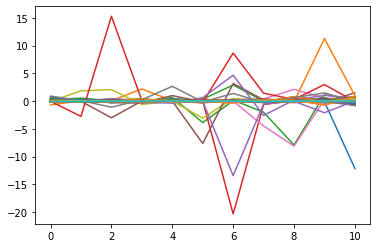

1881

In [74]:
a = clusters_data_list[2]
for c in a['SecurityID']:
    try:
        grpah = new_data[new_data['SecurityID']==c].GSpread.pct_change().dropna().values
        coeffs = pywt.wavedec(grpah, 'db1', level=2)
        plt.plot(coeffs[0])
    except:
        pass
plt.show()
len(a)

### Hierarchical Cluster

In [75]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='complete')  
cluster2_array = cluster.fit_predict(data_scaled)

In [76]:
clusters2 = create_cluster_list(cluster2_array)
clusters_list2 = grab_clusters(clusters2,bond_spread_list,security_data,rating_data)
clusters_data_list2 = transfer_to_list_of_pd(clusters_list2)

#### Show Number of Bonds in each group

In [81]:
for i in clusters_data_list2:
    print(len(i))

1382
2463
9348
3
5
82
2
60
10


### Show the delta GSpreads for the cluster

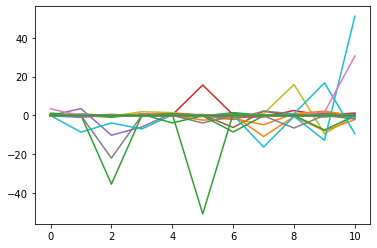

2463

In [82]:
a = clusters_data_list2[1]
for c in a['SecurityID']:
    try:
        grpah = new_data[new_data['SecurityID']==c].GSpread.pct_change().dropna().values
        coeffs = pywt.wavedec(grpah, 'db1', level=2)
        plt.plot(coeffs[0])
    except:
        pass
plt.show()
len(a)